# Grid Cell Phase Coding 

"Phases are in radians, coordinates are in [m] and time base is [ms]. The first data point in XYspkT corresponds with the first spike, which also corresponds with the first phase value"

After changing parameters in the second cell, from the top menu click 'Cell' -> 'Run All' then scroll through

(TODO: add firing map (#spikes/time), variance as lightness in meanphasemap (pi), variance weighting, amount of spikes vs. correlation, temporal separation of spikes vs. correlation, radial distribution of prediction variance, population vector prediction,
low variance phase map?)

(note whether coordinates in numpy [-y,x] or Cartesian [x,y])

In [6]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import seaborn as sns
from scipy.stats import pearsonr
import pycircstat
from scipy import ndimage

%matplotlib inline
np.set_printoptions(suppress=True)
%config InLineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [20, 15]


In [4]:
XYspkT = np.loadtxt('datasets/1/XYspkT.csv',delimiter=',')

#Aligns positions to [0,0] in the bottom-left corner
XYspkT[:,1] -= XYspkT[:,1].min()
XYspkT[:,0] -= XYspkT[:,0].min()
scaled_XY = XYspkT/2

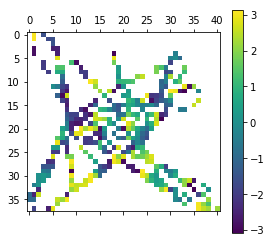

In [149]:
raw = np.loadtxt('datasets/1/MeanPhaseMap.csv',delimiter=',')

#Flipping to align + stripping erraneous values
MeanPhaseMap = np.flip(raw,axis=0)
MeanPhaseMap[0]='NaN'
MeanPhaseMap[:,-1]='NaN'
MeanPhaseMap = MeanPhaseMap[1:-1,:-2]
arena_size = MeanPhaseMap.shape

plt.matshow(MeanPhaseMap)

#To-do: reflect radians in bar
plt.colorbar()

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


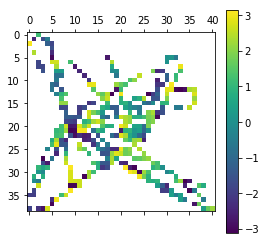

In [243]:
def mean_phase_map(arr,bin_size):
    mpm_dict = {}
    for ybin in range(0,int(arr[:,1].max()+1),bin_size):
        mpm_dict[ybin] = {}
        for xbin in range(0,int(arr[:,0].max()+1),bin_size):
            phases = []
            mpm_dict[ybin][xbin] = []
            for spike in arr:
                if (xbin <= spike[0] <= xbin+bin_size) and (ybin <= spike[1] <= ybin+bin_size):
                    phases.append(spike[2])      
            mpm_dict[ybin][xbin] = pycircstat.mean(np.asarray(phases))

    #Rotate the dataframe 90 CCW
    mpm = pd.DataFrame.from_dict(mpm_dict).T
    phase_df = mpm.reindex(index=mpm.index[::-1])-3.14
    
    #(Uniform) Smoothing algorithm
    #Replaces each value with circular mean of (inclusive) neighbouring 3x3 matrix
    np_dfp = np.pad(phase_df.as_matrix(), 1, 'constant', constant_values=np.nan)
    a = np.zeros((np_dfp.shape[0], np_dfp.shape[1]))

    for i in range(len(np_dfp)-2):
        for j in range(len(np_dfp[i])-2):
            arr = np_dfp[i:i+3,j:j+3]
            if not np.isnan(arr[1,1]):
                n_arr = arr[~np.isnan(arr)]
                avg = pycircstat.mean(n_arr)
                a[i+1,j+1] = avg

    a[a==0]=np.nan
    a = a[1:-1,1:-1]-3.14
    phase_df = pd.DataFrame(a)
    
    return phase_df

phase = np.loadtxt('datasets/1/Phase.csv',delimiter=',')

mpm_arr = np.column_stack((XYspkT,phase))
phase_df = mean_phase_map(mpm_arr,2)

arena_size = phase_df.shape

mcolors.LightSource().blend_hsv()

plt.matshow(ls)

mcolors.L

#To-do: reflect radians in bar
plt.colorbar()

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


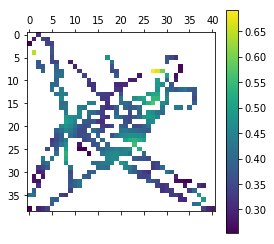

In [249]:
def mean_var_map(arr,bin_size):
    mvm_dict = {}
    for ybin in range(0,int(arr[:,1].max()+1),bin_size):
        mpm_dict[ybin] = {}
        for xbin in range(0,int(arr[:,0].max()+1),bin_size):
            phases = []
            mpm_dict[ybin][xbin] = []
            for spike in arr:
                if (xbin <= spike[0] <= xbin+bin_size) and (ybin <= spike[1] <= ybin+bin_size):
                    phases.append(spike[2])      
            mpm_dict[ybin][xbin] = (pycircstat.var(np.asarray(phases))+0.5)/2

    #Rotate the dataframe 90 CCW
    mvm = pd.DataFrame.from_dict(mpm_dict).T
    var_df = mpm.reindex(index=mpm.index[::-1])
    
    #(Uniform) Smoothing algorithm
    #Replaces each value with circular mean of (inclusive) neighbouring 3x3 matrix
    np_dfp = np.pad(phase_df.as_matrix(), 1, 'constant', constant_values=np.nan)
    a = np.zeros((np_dfp.shape[0], np_dfp.shape[1]))

    for i in range(len(np_dfp)-2):
        for j in range(len(np_dfp[i])-2):
            arr = np_dfp[i:i+3,j:j+3]
            if not np.isnan(arr[1,1]):
                n_arr = arr[~np.isnan(arr)]
                avg = pycircstat.mean(n_arr)
                a[i+1,j+1] = avg

    a[a==0]=np.nan
    a = a[1:-1,1:-1]
    var_df = pd.DataFrame(a)
    
    return var_df

mvm_arr = np.column_stack((XYspkT,phase))
var_df = mean_var_map(mpm_arr,2)

plt.matshow(var_df)

#To-do: reflect radians in bar
plt.colorbar()

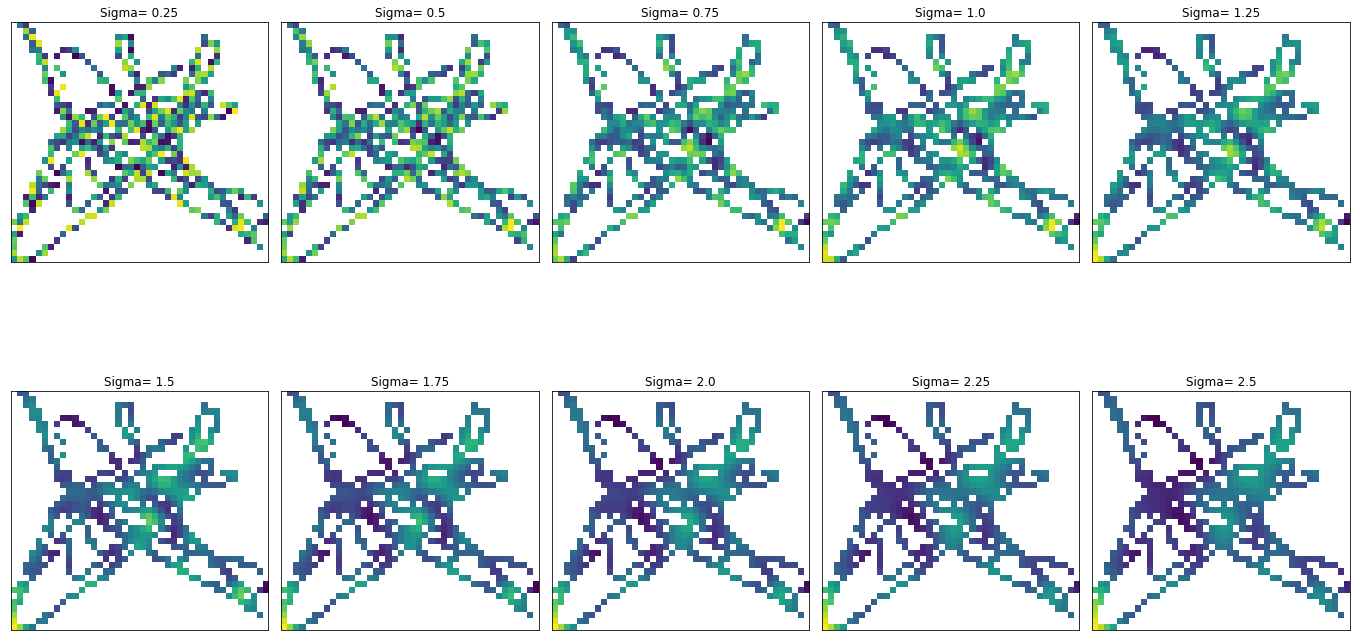

In [146]:
fig, axes = plt.subplots(2,5, figsize=(24, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)
for ax, i in zip(axes.flat, range(1,11)):
    sigma = i/4
    U = np_df
    V=U.copy()
    V[U!=U]=0
    VV=ndimage.gaussian_filter(V,sigma)

    W=0*U.copy()+1
    W[U!=U]=0
    WW=ndimage.gaussian_filter(W,sigma)

    Z = VV/WW
    Z[np.where(np_df==0)]=np.nan
    ax.imshow(Z)
    ax.set_title('Sigma= '+str(i/4))

In [139]:
np_df = np.nan_to_num(phase_df.as_matrix())

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


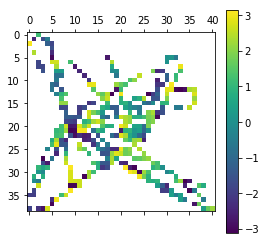

In [239]:
np_dfp = np.pad(phase_df.as_matrix(), 1, 'constant', constant_values=np.nan)
a = np.zeros((np_dfp.shape[0], np_dfp.shape[1]))

for i in range(len(np_dfp)-2):
    for j in range(len(np_dfp[i])-2):
        arr = np_dfp[i:i+3,j:j+3]
        if not np.isnan(arr[1,1]):
            n_arr = arr[~np.isnan(arr)]
            avg = pycircstat.mean(n_arr)
            a[i+1,j+1] = avg

a[a==0]=np.nan
a = a[1:-1,1:-1]-3.14
plt.matshow(pd.DataFrame(a[1:-1,1:-1])-3.14)
plt.colorbar()

(array([38., 39., 37., 41., 44., 35., 38., 40., 35., 27.]),
 array([-3.12042196, -2.4945755 , -1.86872904, -1.24288258, -0.61703612,
         0.00881035,  0.63465681,  1.26050327,  1.88634973,  2.51219619,
         3.13804265]),
 <a list of 10 Patch objects>)

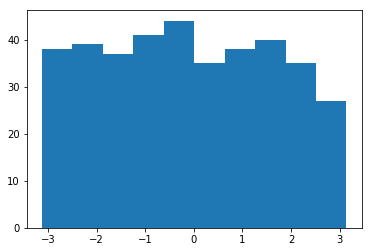

In [185]:
plt.hist(np_dfp.flat)

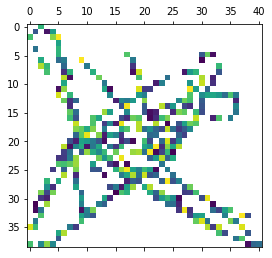

In [186]:
plt.matshow(phase_df)